In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")

In [ ]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy

from optimizer import set_parameter_requires_grad, initialize_model, train_and_test, test_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# classic dataset 
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

100%|██████████| 170498071/170498071 [00:02<00:00, 83022485.91it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [ ]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [ ]:
labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets 
print(labels)

[0 1 2 3 4 5 6 7 8 9]


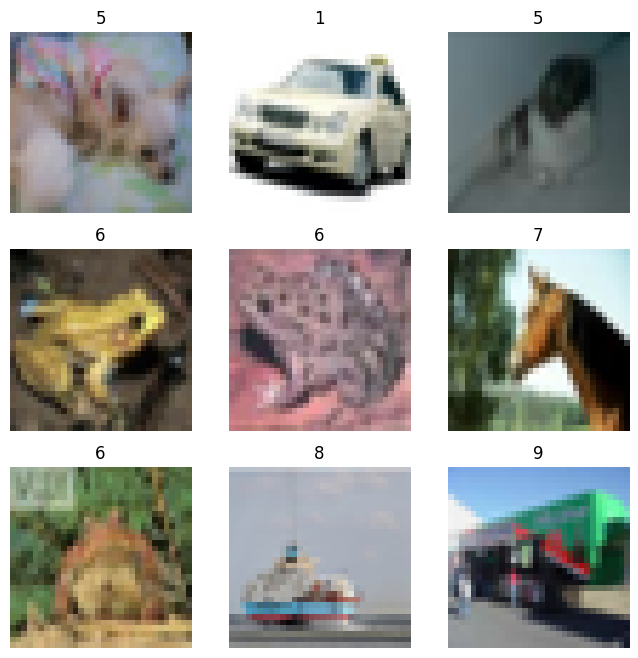

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
batch_size = 16
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
req_grad = True

# Initialize the model for this run
model, input_size = initialize_model(use_pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [ ]:
# Send the model to GPU
model = model.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if req_grad:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
lr=0.01
momentum=0.
optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()
num_epoch = 20
path='./drive/MyDrive/Opti-ML/model_weights/model_test_sgd_0522.pt'

In [ ]:
train_loss, list_testloss, lowest_loss, model_weights=train_and_test(model, trainloader,testloader, criterion, optimizer,num_epoch,path,device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 1.1193


  5%|▌         | 1/20 [00:53<17:01, 53.75s/it]

Test Loss: 0.7274
Epoch 1/19
----------
Train Loss: 0.7624


 10%|█         | 2/20 [01:39<14:41, 48.96s/it]

Test Loss: 0.6346
Epoch 2/19
----------
Train Loss: 0.6161


 15%|█▌        | 3/20 [02:26<13:37, 48.10s/it]

Test Loss: 0.5750
Epoch 3/19
----------
Train Loss: 0.5204


 20%|██        | 4/20 [03:12<12:34, 47.15s/it]

Test Loss: 0.6532
Epoch 4/19
----------
Train Loss: 0.4502


 25%|██▌       | 5/20 [03:58<11:44, 46.97s/it]

Test Loss: 0.5296
Epoch 5/19
----------
Train Loss: 0.3797


 30%|███       | 6/20 [04:44<10:52, 46.62s/it]

Test Loss: 0.5819
Epoch 6/19
----------
Train Loss: 0.3310


 35%|███▌      | 7/20 [05:31<10:08, 46.79s/it]

Test Loss: 0.6121
Epoch 7/19
----------
Train Loss: 0.2854


 40%|████      | 8/20 [06:17<09:18, 46.54s/it]

Test Loss: 0.5517
Epoch 8/19
----------
Train Loss: 0.2514


 45%|████▌     | 9/20 [07:05<08:34, 46.76s/it]

Test Loss: 0.6105
Epoch 9/19
----------
Train Loss: 0.2189


 50%|█████     | 10/20 [07:50<07:44, 46.46s/it]

Test Loss: 0.6383
Epoch 10/19
----------
Train Loss: 0.1949


 55%|█████▌    | 11/20 [08:38<07:00, 46.77s/it]

Test Loss: 0.5958
Epoch 11/19
----------
Train Loss: 0.1699


 60%|██████    | 12/20 [09:24<06:13, 46.71s/it]

Test Loss: 0.6059
Epoch 12/19
----------
Train Loss: 0.1465


 65%|██████▌   | 13/20 [10:11<05:27, 46.79s/it]

Test Loss: 0.6577
Epoch 13/19
----------
Train Loss: 0.1318


 70%|███████   | 14/20 [10:57<04:39, 46.53s/it]

Test Loss: 0.7561
Epoch 14/19
----------
Train Loss: 0.1213


 75%|███████▌  | 15/20 [11:44<03:52, 46.58s/it]

Test Loss: 0.6971
Epoch 15/19
----------
Train Loss: 0.1039


 80%|████████  | 16/20 [12:30<03:05, 46.41s/it]

Test Loss: 0.7008
Epoch 16/19
----------
Train Loss: 0.0962


 85%|████████▌ | 17/20 [13:17<02:19, 46.49s/it]

Test Loss: 0.7055
Epoch 17/19
----------
Train Loss: 0.0862


 90%|█████████ | 18/20 [14:03<01:32, 46.36s/it]

Test Loss: 0.7094
Epoch 18/19
----------
Train Loss: 0.0781


 95%|█████████▌| 19/20 [14:50<00:46, 46.54s/it]

Test Loss: 0.7544
Epoch 19/19
----------
Train Loss: 0.0680


100%|██████████| 20/20 [15:36<00:00, 46.82s/it]

Test Loss: 0.7202


In [ ]:
testloader = DataLoader(test_data, batch_size=1, shuffle=True)
accuracy = test_model(model,testloader,path,device)
print(f"accuracy={accuracy}")

accuracy=0.8259


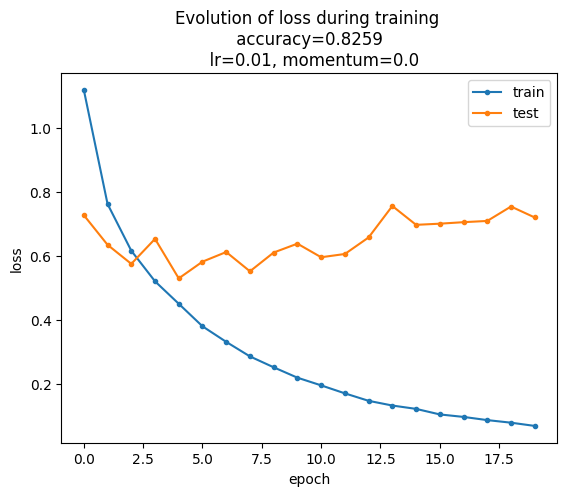

In [ ]:
plt.plot(train_loss,'.-')
plt.plot(list_testloss,'.-')
plt.title(f"Evolution of loss during training \n accuracy={accuracy} \n  lr={lr}, momentum={momentum}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"])
plt.savefig("drive/MyDrive/Opti-ML/graphics/SGD_test1_loss.pdf")